In [66]:
#===============================================================================
# carabao/cell package: copyright: Neuronycs 2023
# - class Cell
#===============================================================================

import numpy
from numpy import transpose as trn
from numpy import ones, arange, copy, array
#from carabao.screen import norm1,select

#=============================================================================
# select function
#=============================================================================

def select(K,c):
    """
    select(): select a set of neuron outputs given an index matrix/list and
              a context vector c

                  c = [0,0,0,1,1, 1,1,0,0,0]
                  g = [0,1,2];
                  v = select(g,c)

                  K = numpy.array([[4,5,6,7],[6,7,8,9]])
                  V = select(K,c)

              see also: Cell, Rcell, hash, norm1
    """
    if type(K).__name__ == 'list':
        return [c[k] for k in K];

    if type(K).__name__ != 'ndarray':
        raise Exception('numpy array expected')

    V = copy(K);       # make a copy
    for i in range(0,K.shape[0]):
        for j in range(0,K.shape[1]):
            V[i,j] = c[K[i,j]]

    return V

#===============================================================================
# helper: vector 1-norm or matrix 1-norm
#===============================================================================

def norm1(M):    # max of row sums
    """
    norm1(): vector 1-norm or matrix 1-norm

                 v = [2,-3,-1]      # list representation of vector
                 n = norm1(v)       # sum of abs values => n = 6

                 V = numpy.array([[2,-3,-1],[1,0,-1]])
                 n = norm1(V)       # max of row 1-norm => n = max(6,2) =6

             see also: Cell, select, hash
    """
    if type(M).__name__ == 'list':
        return sum(M)

    result = 0
    for j in range(0,M.shape[0]):
        sumj = M[j].sum().item()
        result = result if sumj < result else sumj
    return result

#=============================================================================
# class Cell
#=============================================================================

class Rcell:
    """
    Rcell: class Rcell - modelling HTM cell algorithm

        from carabao.screen import Monitor
        from carabao.cell import Cell,toy
        from numpy import ones

        mon = Monitor(m=1,n=3)
        k,g,K,P,c = toy('cell')
        cell = Rcell(mon,k,g,K,P)
        cell.plot(i=0,j=0)    # plot at monitor location i,j

        cell.u = cell.y = cell.x = cell.b = 1
        cell.plot(i=0,j=1)    # plot at monitor location i,j

        v = [1,0,1,0];  V = ones((2,5));  E = (cell.P >= 0.5)*V
        cell.plot(0,2,v,E)
    """

    def __init__(self,mon,k,g,K,P):
        self.mon = mon.copy()  # Monitor(mon.screen.m,mon.screen.n,mon.verbose)
        zero = [0 for i in range(0,P.shape[0])]

            # input, output, state variables

        self.u = 0                     # basal (feedforwad) input
        self.y = 0                     # cell output (axon)
        self.x = 0                     # predictive state
        self.b = 0                     # burst state
        self.s = zero                  # spike state
        self.P = P                     # permanence matrix (state)

            # parameters and auxilliary variables

        self.config(k,g,K)
        self.x_ = 0                    # auxilliary: x(t+1)
        self.P_ = self.P               # auxilliary: P(t+1)

    def config(self,k,g,K):
        self.eta = 0.5                 # synaptic threshold
        self.theta = 2                 # dendritic threshold
        self.pdelta = 0.04             # positive learning delata
        self.ndelta = 0.02             # negative learning delta
        self.k = k;
        self.g = g;
        self.K = K;

    def transition(self):              # state & permanence transition
        self.x = self.x_               # predictive state transition
        self.P = self.P_               # permanence state transition

    def update(self,c):                # update context with current output
        c[self.k] = self.y             # update context with changed output
        return c                       # return updated context

    def phase1(self,u,c):              # cell algo phase 1: update context
        self.transition()              # first perform state transition

            # rule 1: excited (u=1) & predictive (x=1) cells get active (y=1)

        self.u = u;                    # store input locally
        self.y = u * self.x            # excited & predictive cells get active
        #self.b = 0                    # clear burst state

            # update context c[k] with updated output y
            # note: c is only updated but not used for processing

            # record/log quantities (if verbose)

        self.mon.record(self,u,c)      # record current cell state
        return self.update(c)          # return updated context

    def phase2(self,u,c):              # cell algo phase 2: bursting
        self.u = u

           # rule 2: excited cells in a non-predictive group get bursting

        v = [c[k] for k in self.g]     # the group's outputs
        self.b = u * (sum(v) == 0)     # set cell's burst state

           # important: don't change output (and context vector) in this phase
           # before all cells in the context have determined their burst state

        self.mon.record(self,u,c,v)
        return self.update(c)          # return updated context

    def phase3(self,u,c):              # cell algo phase 3: process context
        self.u = u

            # rule 3: excited bursting cells get active

        self.y = self.y or (u * self.b)

            # rule 4: excided empowered dendritic segments are spiking

        V = self.select(c,self.K)          # pre-synaptic signals
        W = (self.P >= self.eta)           # synaptic (binary) weights
        E = V * W                          # synapitcs matrix
        self.s = self.spike(u,E,self.theta)

            # rule 5: spiking dentrites of activated cells are learning
            # (calc permanences after transition)

        L = self.learn(E)
        D = self.y * (L*E*self.pdelta - L*self.ndelta)

        self.P_ = self.P + D           # learning (permanences after transition)

            # rule 6: active cells with spiking dendrites get predictive
            # (calc state after transition)

        self.x_ = self.y * max(self.s) # get predictive if any segment spikes

            # record this stuff

        self.mon.record(self,u,c,0,V,W,E,L,D)
        return self.update(c)          # return updated context

    def phase(self,ph,u,c):            # cell algo phase i
        if ph == 1:
            return self.phase1(u,c)
        elif ph == 2:
            return self.phase2(u,c)
        elif ph == 3:
            return self.phase3(u,c)
        else:
            raise Exception("bad phase")

    def select(self,c,K):              # pre-synaptic signals
        V = 0*K
        for mu in range(0,K.shape[0]):
            for nu in range(0,K.shape[1]):
                V[mu,nu] = c[K[mu,nu]];
        return V

    def spike(self,u,E,theta):         # generate spike vector from Empowerment
        return [u * (sum(E[mu]) >= theta)
                for mu in range(0,E.shape[0])]

    def group(self,c,g):
        return [c[g[k]] for k in range(0,len(g))]

    def learn(self,E):                  # learning vector
        d,s = E.shape
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(E[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = trn(array([p])) @ ones((1,s))
        return L

    def up_date(self,u,c,args):
        self.u = u                     # store for analysis
        c[self.k] = self.y             # update context with changed output
        return c

      ### rule 1: spiking cells get predictive

    def rule1(self,u,c):
        self.x = max(self.s)  # cell gets predictive when any dendrite spikes
        return self.up_date(u,c,[1])

      ### rule 2: excited (u=1) & predictive (x=1)  

    def rule2(self,u,c):   
        self.y = u * self.x            # excited & predictive cells get active
        return self.up_date(u,c,[2])

    def plot(self,i=None,j=None,v=None,W=None,E=None,xlabel=None,head=None,foot=None):
        self.mon.plot(self,i,j,v,W,E)
        if xlabel is not None:
            self.mon.xlabel(j,xlabel)
        if head is not None:
            self.head(head)
        if foot is not None:
            self.foot(foot)


#===============================================================================
# class Toy
# - usage: k,g,P,K = Toy('cell')
#===============================================================================

def toy(tag):
    """
    Toy: create a toy object

       k,g,K,P,c = toy('cell')
       k,g,K,P,c = toy('mini3')
    """
    if tag == 'cell':
        k = 0                        # cell index
        g = [0,1,2,4]                  # group indices
        K = array([[1,3,5,7,9],[3,4,5,6,7]])
        P = array([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])
        c = [0,0,0,0,1,1,0,0,1,1];
        return k,g,K,P,c
    elif tag == 'mini3':
        k = [0,1,2]                  # cell indices
        g = [0,1,2]                  # group indices
        K0 = array([[3,4,5,6,7],[1,3,5,7,9]])
        K1 = array([[4,5,6,7,8],[2,4,5,6,7]])
        K2 = array([[5,6,7,8,9],[0,3,7,8,9]])
        P0 = array([[0.5,0.6,0.1,0.2,0.3],[0.0,0.6,0.4,0.0,0.0]])
        P1 = array([[0.1,0.3,0.5,0.1,0.0],[0.0,0.6,0.5,0.7,0.0]])
        P2 = array([[0.0,0.1,0.5,0.7,0.1],[0.0,0.1,0.3,0.8,0.0]])
        K = [K0,K1,K2]
        P = [P0,P1,P2]
        c = [0,0,0,0,1,1,0,0,1,1];
        return k,g,K,P,c
    else:
        raise Exception('unknown tag')

def hello():
	print("hello, world!")


c: [0, 0, 0, 0, 1, 1, 0, 0, 1, 1]


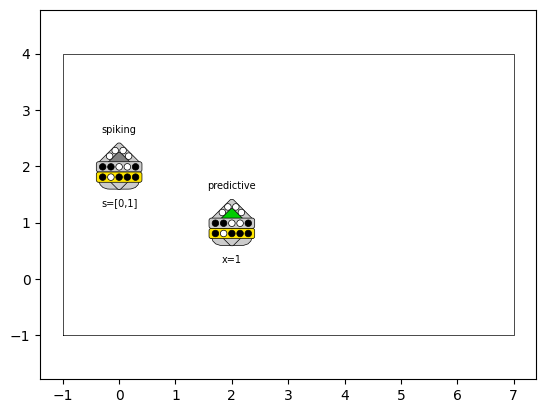

In [67]:
# basic states of HTM neuron

from carabao.screen import Monitor
mon = Monitor(m=4,n=7)

k,g,K,P,c = toy('cell'); 
print("c:",c)

    # create a cell and initialize it as spiking

cell = Rcell(mon,k,g,K,P)
cell.s = [0,1]
cell.plot(1,0,head='spiking',foot='s=[0,1]')

   # let the cell spike, set input and apply rule 1

u = 0
c = cell.rule1(u,c)
cell.plot(2,2,head='predictive',foot='x=1')


In [3]:
# common stuff

k,g,K,P,c = toy('cell'); 
u = 1
print("c:",c)

def locate(mon,i,j,txt='',u=None,x=None,y=None,b=None,s=None):
    cell = Rcell(mon,k,g,K,P)
    cell.u = u if u is not None else cell.u;  
    cell.x = x if x is not None else cell.x;  
    cell.y = y if y is not None else cell.y;  
    cell.b = b if b is not None else cell.b;  
    cell.s = s if s is not None else cell.s;  
    cell.plot(i,j)
    mon.text(j,3-i-2+0.3,txt)
    return cell

c: [0, 0, 0, 0, 1, 1, 0, 0, 1, 1]


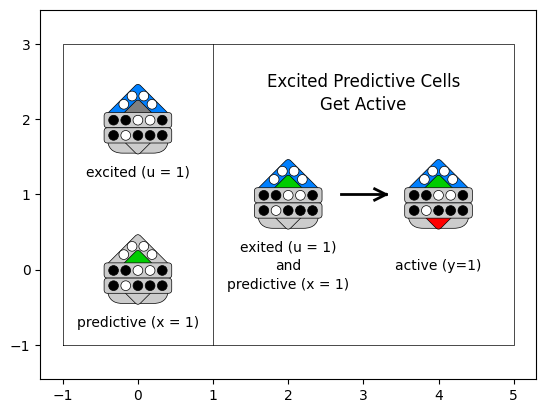

In [4]:
# rule 2: excited (u=1) predictive (x=1) cells get active (y=1)

mon = Monitor(m=3,n=4)
locate(mon,0,0,'excited (u = 1)',u=1)
locate(mon,2,0,'predictive (x = 1)',x=1)

mon.separator(1.5)
cell = locate(mon,1,2,'exited (u = 1)',u=1,x=1)
mon.text(2,.05,'and')
mon.text(2,-.2,'predictive (x = 1)')

cell.rule2(u,c)
cell.plot(1,4)
mon.text(4,.05,'active (y=1)')

def arrow(x,y,a=0.8,b=0.15):
    mon.line([x,x+a],[y,y],linewidth=2)
    mon.line([x+a-b,x+a],[y+b/2,y],linewidth=2)
    mon.line([x+a-b,x+a],[y-b/2,y],linewidth=2)

arrow(2.7,1,0.6)
mon.text(3,2.5,'Excited Predictive Cells',size=12)
mon.text(3,2.2,'Get Active',size=12)